#**Preparations of the environment**#
check that all the imports are used!!!



In [0]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from   torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.bottleneck as bottleneck


#to visualize data
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':100,
    'num_epochs':12,
    'val_batch_size':100,
    'num_classes':10,
    'learning_rate':1e-3,
    'log_interval':100,
    'train_percentage':0.95,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

#**EXERCISE 1 : Convolutional Autoencoder**

##1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.




In [3]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
initial_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_size = int(hparams['train_percentage'] * len(initial_data))
validation_size = len(initial_data) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(initial_data, [train_size, validation_size])
test_dataset = test_data

print("Train data length:", len(train_dataset))
print("Validation data length:", len(validation_dataset))
print("Test data length:", len(test_dataset))
print()

# data loaders by choosing batch_size
batch_size = 20 #number of samples per batch

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=hparams['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=hparams['batch_size'], shuffle=True)

# check if the loaders are working
# We can retrieve a sample from the dataset by simply indexing it (cf lab 04)
img, label = train_dataset[0]
print('Training img shape: ', img.shape, 'with this label: ', label)
img, label = validation_dataset[0]
print('Validation img shape: ', img.shape, 'with this label: ', label)
img, label = test_dataset[0]
print('Testing img shape: ', img.shape, 'with this label: ', label)



0it [00:00, ?it/s]

9920512it [00:04, 2273644.14it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 55989.28it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 842718.77it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21119.42it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
Train data length: 57000
Validation data length: 3000
Test data length: 10000

Training img shape:  torch.Size([1, 28, 28]) with this label:  7
Validation img shape:  torch.Size([1, 28, 28]) with this label:  5
Testing img shape:  torch.Size([1, 28, 28]) with this label:  7


## 2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).

**a) preparation**


In [0]:
# BET: I've copied all the imports at the start of the notebook to keep it organised

# counts the number of parameters of a model
def model_params(model):
    # from: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
    number_of_paremeters=0
    for parameter in list(model.parameters()):
        neural_network=1
        for size_index in list(parameter.size()):
            neural_network = neural_network*size_index
        number_of_paremeters += neural_network
    return number_of_paremeters

**b) encoder**

In [5]:
#take bottleneck size as parameter for bottleneck size (TODO)
class encode(nn.Module):
  ## encode ##
  def __init__(self):
    super(encode, self).__init__()
    ## encoder layers ##
    # conv layer (depth from 1 --> 16), 3x3 kernels
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
    # conv layer (depth from 16 --> 4), 3x3 kernels
    self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
    # pooling layer to reduce x-y dims by two; kernel and stride of 2
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self,x):
    # add hidden layers with relu activation function
    # and maxpooling after
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    # add second hidden layer
    x = F.relu(self.conv2(x))
    x = self.pool(x)  # compressed representation

    #we need at least one linear layer for bottlenecks!! (TODO)

    return x

myEncoder = encode()
print(myEncoder)
print("myEncoder has",model_params(myEncoder), "parameters")

encode(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
myEncoder has 740 parameters


**c) decoder**

In [6]:
#take bottleneck size as parameter for bottleneck size (TODO)
class decode(nn.Module):
  def __init__(self):
    super(decode, self).__init__()
    ## decoder layers ##
    ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
    self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

  def forward(self,code):
    ## decode ##
    # add transpose conv layers, with relu activation function
    x = F.relu(self.t_conv1(code))
    # output layer (with sigmoid for scaling from 0 to 1)
    x = F.sigmoid(self.t_conv2(x))
    return x


myDecoder = decode()
print(myDecoder)
print("myDecoder has",model_params(myDecoder), "parameters")

decode(
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)
myDecoder has 337 parameters



## 3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.

In [0]:
def train_epoch(train_loader, EncoderModel, DecoderModel, optimizer, criterion, hparams, epoch):
  # Activate the train=True flag inside the model
  EncoderModel.train()
  DecoderModel.train()
  
  #initiate loss to 0
  loss = 0.0
  losses = []

  for batch_idx, (data) in enumerate(train_loader, 1):
      data = data[0].to(hparams['device']) #index 0 is for image, index 1 for the labels
      optimizer.zero_grad()

      #compute the output
      firstOutput = EncoderModel(data)
      outputs = DecoderModel(firstOutput)
      
      #compare it to the input data
      loss = criterion(outputs, data)
      
      loss.backward()
      losses.append(loss.item())
      optimizer.step()

      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
  
  return np.mean(losses)


In [0]:
# IS THERE SOMETHING WRONG IN THIS CODE CAUSE WE ARE UNDERFITIING? (TODO)
# we need to add accuracy in there (TODO)
def eval_epoch(eval_loader,  EncoderModel, DecoderModel, criterion, hparams):
  # Activate the validation=True flag inside the model
  EncoderModel.eval()
  DecoderModel.eval()
  
  eval_loss = 0

  with torch.no_grad():
      for data in eval_loader:
          data = data[0].to(hparams['device']) #index 0 is for image, index 1 for the labels

          #compute the output
          firstOutput = EncoderModel(data)
          outputs = DecoderModel(firstOutput)

          #same as in training cause we have an autoencoder
          eval_loss += criterion(outputs, data).item() # sum up batch loss

      # mean of the validation error    
      eval_loss /= len(eval_loader.dataset)

  print('Eval set: Average loss: {:.10f}'.format(eval_loss))
  return eval_loss

In [0]:
train_losses = []
eval_losses = []

criterion = nn.MSELoss()

#initialize models
myEncoder = encode()  
myDecoder = decode()


# we will need to define bottleneck numbers (TODO)
def train_autoencoder(number_of_bottleneck):
  myEncoder.train()
  myDecoder.train()
  
  myEncoder.to(hparams['device'])
  myDecoder.to(hparams['device'])

  #isn't the optimizer for both models parameters?? (check this out: https://github.com/mbsariyildiz/autoencoder-pytorch/blob/master/src/train.py)
  optimizer = optim.Adam(list(myEncoder.parameters()) + list(myDecoder.parameters()), lr=hparams['learning_rate'])
  
  for epoch in range(1, hparams['num_epochs'] + 1):
    tr_loss = train_epoch(train_loader, myEncoder, myDecoder, optimizer, criterion, hparams, epoch)
    te_loss = eval_epoch(validation_loader, myEncoder, myDecoder, criterion, hparams)
    eval_losses.append(te_loss)
    train_losses.append(tr_loss)
  rets = {'train_losses':train_losses, 'eval_losses':eval_losses}


In [19]:
#let's now train it
train_autoencoder(1)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [10000/57000 (18%)]	Loss: 0.012084
Train Epoch: 1 [20000/57000 (35%)]	Loss: 0.012002
Train Epoch: 1 [30000/57000 (53%)]	Loss: 0.012432
Train Epoch: 1 [40000/57000 (70%)]	Loss: 0.010782
Train Epoch: 1 [50000/57000 (88%)]	Loss: 0.012590
Train Epoch: 1 [57000/57000 (100%)]	Loss: 0.011789
Eval set: Average loss: 0.0001169426
Train Epoch: 2 [10000/57000 (18%)]	Loss: 0.012385
Train Epoch: 2 [20000/57000 (35%)]	Loss: 0.011586
Train Epoch: 2 [30000/57000 (53%)]	Loss: 0.011754
Train Epoch: 2 [40000/57000 (70%)]	Loss: 0.010628
Train Epoch: 2 [50000/57000 (88%)]	Loss: 0.011489
Train Epoch: 2 [57000/57000 (100%)]	Loss: 0.011424
Eval set: Average loss: 0.0001151488
Train Epoch: 3 [10000/57000 (18%)]	Loss: 0.011279
Train Epoch: 3 [20000/57000 (35%)]	Loss: 0.011944
Train Epoch: 3 [30000/57000 (53%)]	Loss: 0.011763
Train Epoch: 3 [40000/57000 (70%)]	Loss: 0.012322
Train Epoch: 3 [50000/57000 (88%)]	Loss: 0.012094
Train Epoch: 3 [57000/57000 (100%)]	Loss: 0.010977
Eval set: Average loss:

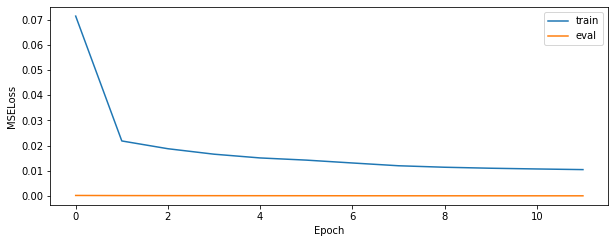

In [12]:
#plots loss curves (something went wrong with validation)
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')
plt.plot(train_losses, label='train')
plt.plot(eval_losses, label='eval')
plt.legend()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


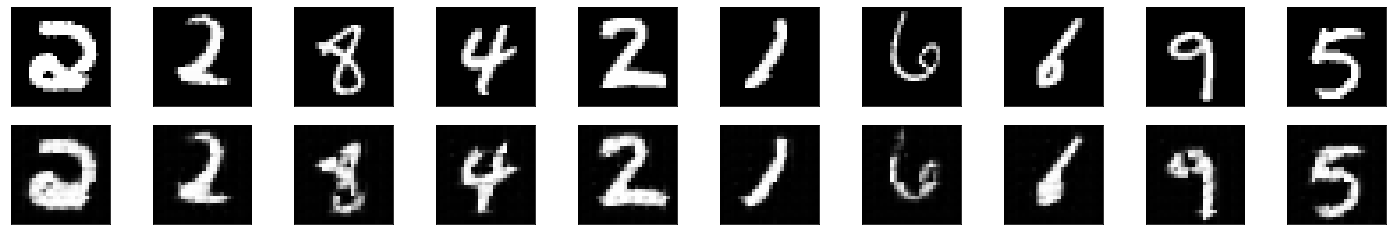

In [14]:
#let's display the input and output here after testing
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs (we need to retrieve test_losses)
test_losses = [] #TODO
encodedImages = myEncoder(images)
output = myDecoder(encodedImages)
# prep images for display
images = images.numpy()

# output is resized into a batch of images >>> not needed
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## 4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including number of parameters of each model.

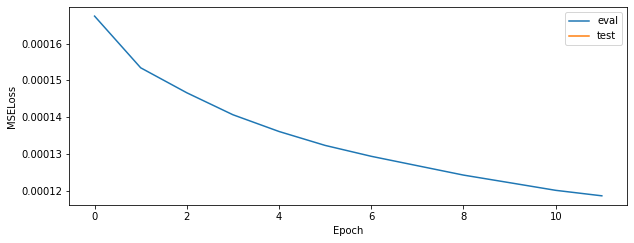

In [17]:
#plots avg. image reconstruction error (MSE) (validation and tests)
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')
plt.plot(eval_losses, label='eval')
plt.plot(test_losses, label='test') #TODO
plt.legend()

## 5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.


## 6. Generate 5 new images by injecting random values as input to the decoder. Show them.

# **EXERCISE 2 : Transfer Learning**

## 1. Select a subset of 100 images and their associated labels from the MNIST training data.

## 2. Select one of the previously trained autoencoders.

## 3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

## 4. Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.

## 5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

## 6. From scratch: train the model on the 100 samples without reusing the decoder weights at all.

## 7. Show the accuracy of the four models on the MNIST test set in a table.